In [ ]:
!git clone https://github.com/tommylees112/crop_yield_prediction.git

Cloning into 'crop_yield_prediction'...
remote: Enumerating objects: 177, done.
remote: Total 177 (delta 0), reused 0 (delta 0), pack-reused 177
Receiving objects: 100% (177/177), 3.23 MiB | 33.05 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/crop_yield_prediction/3_model

/content/crop_yield_prediction/3_model


In [ ]:
%tensorflow_version 1.x
from nnet_for_hist_dropout_stride import *
from GP_crop_v3 import *
import logging
from tqdm import tqdm

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [ ]:
predict_year = 2013
logging.basicConfig(filename='train_for_hist_alldata'+str(predict_year)+'.log',level=logging.DEBUG)
# Create a coordinator
config = Config()

In [ ]:
config.load_path = "/content/drive/MyDrive/Crop_Yield/img_full_output1/"
config.save_path = '/content/drive/MyDrive/Crop_Yield/monthly/'

In [ ]:
# load data to memory
filename = 'histogram_all_full' + '.npz'
# filename = 'histogram_all_soilweather' + '.npz'
content = np.load(config.load_path + filename)
image_all = content['output_image']
yield_all = content['output_yield']
year_all = content['output_year']
locations_all = content['output_locations']
index_all = content['output_index']

In [ ]:
image_all.shape

(19078, 32, 32, 9)

In [ ]:
list_delete=[]
for i in tqdm(range(image_all.shape[0])):
    if np.sum(image_all[i,:,:,:])<=287:
        if year_all[i]<2013:
            list_delete.append(i)
image_all=np.delete(image_all,list_delete,0)
yield_all=np.delete(yield_all,list_delete,0)
year_all = np.delete(year_all,list_delete, 0)
locations_all = np.delete(locations_all, list_delete, 0)
index_all = np.delete(index_all, list_delete, 0)

100%|██████████| 19078/19078 [00:00<00:00, 66607.51it/s]


In [ ]:
# keep major counties
list_keep=[]
for i in tqdm(range(image_all.shape[0])):
    if (index_all[i,0]==5)or(index_all[i,0]==17)or(index_all[i,0]==18)or(index_all[i,0]==19)or(index_all[i,0]==20)or(index_all[i,0]==27)or(index_all[i,0]==29)or(index_all[i,0]==31)or(index_all[i,0]==38)or(index_all[i,0]==39)or(index_all[i,0]==46):
        list_keep.append(i)
image_all=image_all[list_keep,:,:,:]
yield_all=yield_all[list_keep]
year_all = year_all[list_keep]
locations_all = locations_all[list_keep,:]
index_all = index_all[list_keep,:]

100%|██████████| 5285/5285 [00:00<00:00, 211016.84it/s]


In [ ]:
np.nonzero(year_all == predict_year)[0]

array([ 732,  733,  734,  735,  736,  737,  738,  739,  740,  741,  742,
        743,  744,  745,  746,  747,  748,  749,  750,  751,  752,  753,
        754,  755,  756,  757,  758,  759,  760,  761,  762,  763,  764,
        765,  766,  767,  768,  769,  770,  771,  772,  773,  774,  775,
        776,  777,  778,  779,  780,  781,  782,  783,  784,  785,  786,
        787,  788,  789,  790,  791,  792,  793,  794,  795,  796,  797,
        798,  799,  800,  801,  802,  803,  804,  805,  806,  807,  808,
        809,  810,  811,  812,  813,  814,  815,  816,  817,  818,  819,
        820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,
        831,  832,  833,  834,  835,  836,  837,  838,  839,  840,  841,
        842,  843,  844,  845,  846,  847,  848,  849,  850,  851,  852,
        853,  854,  855,  856,  857,  858,  859,  860,  861,  862,  863,
        864,  865,  866,  867,  868,  869,  870,  871,  872,  873,  874,
        875,  876,  877,  878,  879,  880,  881,  8

In [ ]:
# split into train and validate
index_train = np.nonzero(year_all > predict_year)[0]
index_validate = np.nonzero(year_all == predict_year)[0]
print('train size',index_train.shape[0])
print('validate size',index_validate.shape[0])

train size 2238
validate size 712


In [ ]:
# calc train image mean (for each band), and then detract (broadcast)
image_mean=np.mean(image_all[index_train],(0,1,2))
image_all = image_all - image_mean

In [ ]:
image_validate=image_all[index_validate]
yield_validate=yield_all[index_validate]

In [ ]:
model= NeuralModel(config,'net')




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 8192)




In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.22)
# Launch the graph.
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.initialize_all_variables())

summary_train_loss = []
summary_eval_loss = []
summary_RMSE = []
summary_ME = []

train_loss=0
val_loss=0
val_prediction = 0
val_deviation = np.zeros([config.B])
# #########################
# block when test
# add saver
saver=tf.train.Saver()
# Restore variables from disk.

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
try:
    saver.restore(sess, config.save_path+str(predict_year)+"CNN_model.ckpt")
# Restore log results
    npzfile = np.load(config.save_path + str(predict_year)+'result.npz')
    summary_train_loss = npzfile['summary_train_loss'].tolist()
    summary_eval_loss = npzfile['summary_eval_loss'].tolist()
    summary_RMSE = npzfile['summary_RMSE'].tolist()
    summary_ME = npzfile['summary_ME'].tolist()
    print("Model restored.")
except:
    print('No history model found')
# #########################

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Crop_Yield/monthly/2013CNN_model.ckpt
Model restored.


In [ ]:
summary_train_loss = summary_train_loss.tolist()
summary_eval_loss = summary_eval_loss.tolist()
summary_RMSE = summary_RMSE.tolist()
summary_ME = summary_ME.tolist()
type(summary_train_loss)


list

predict year2013step0 87890.28 14829.418 0.001
Validation set RMSE 31.116117670548256 ME -29.22646187193353 RMSE_min 31.116117670548256
predict year2013step200 9114.863 12526.868 0.001
Validation set RMSE 25.43473233388875 ME -22.409483282809905 RMSE_min 25.43473233388875
predict year2013step400 8220.102 9585.44 0.001
Validation set RMSE 25.10583319627151 ME -19.963709864579144 RMSE_min 25.10583319627151
predict year2013step600 7256.6836 13330.956 0.001
Validation set RMSE 30.092667777099845 ME -19.78281565186652 RMSE_min 25.10583319627151
predict year2013step800 6198.077 11540.293 0.001
Validation set RMSE 29.805311383460833 ME -18.61404123434966 RMSE_min 25.10583319627151
predict year2013step1000 5617.538 14587.287 0.001
Validation set RMSE 29.403298035276386 ME -15.599011598730629 RMSE_min 25.10583319627151
predict year2013step1200 4673.81 14815.233 0.001
Validation set RMSE 31.843510102688573 ME -20.506893637573175 RMSE_min 25.10583319627151
predict year2013step1400 2997.6929 12140

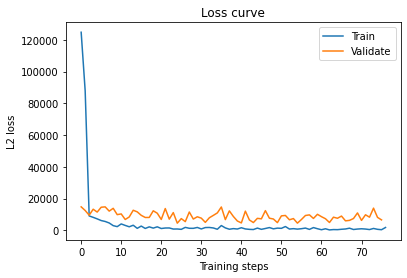

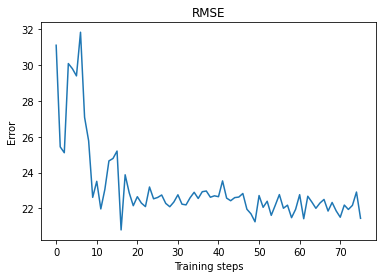

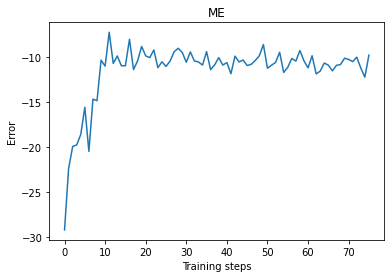

In [ ]:
RMSE_min = 100
try:
    for i in range(config.train_step):
        if i==3500:
            config.lr/=10
            # saver.restore(sess, config.save_path+str(predict_year)+"CNN_model.ckpt")
            # # Restore log results
            # npzfile = np.load(config.save_path + str(predict_year)+'result.npz')
            # summary_train_loss = npzfile['summary_train_loss'].tolist()
            # summary_eval_loss = npzfile['summary_eval_loss'].tolist()
            # summary_RMSE = npzfile['summary_RMSE'].tolist()
            # summary_ME = npzfile['summary_ME'].tolist()
            # print("Model restored.")
        if i==20000:
            config.lr/=10
            # saver.restore(sess, config.save_path+str(predict_year)+"CNN_model.ckpt")
            # # Restore log results
            # npzfile = np.load(config.save_path + str(predict_year)+'result.npz')
            # summary_train_loss = npzfile['summary_train_loss'].tolist()
            # summary_eval_loss = npzfile['summary_eval_loss'].tolist()
            # summary_RMSE = npzfile['summary_RMSE'].tolist()
            # summary_ME = npzfile['summary_ME'].tolist()
            # print("Model restored.")
        # if i==12000:
        #     config.lr/=10
            # saver.restore(sess, config.save_path+str(predict_year)+"CNN_model.ckpt")
            # # Restore log results
            # npzfile = np.load(config.save_path + str(predict_year)+'result.npz')
            # summary_train_loss = npzfile['summary_train_loss'].tolist()
            # summary_eval_loss = npzfile['summary_eval_loss'].tolist()
            # summary_RMSE = npzfile['summary_RMSE'].tolist()
            # summary_ME = npzfile['summary_ME'].tolist()
            # print("Model restored.")

        # No augmentation
        # index_train_batch = np.random.choice(index_train,size=config.B)
        # image_train_batch = image_all[index_train_batch,:,0:config.H,:]
        # yield_train_batch = yield_all[index_train_batch]
        # year_train_batch = year_all[index_train_batch,np.newaxis]

        # try data augmentation while training
        index_train_batch_1 = np.random.choice(index_train,size=config.B)
        index_train_batch_2 = np.random.choice(index_train,size=config.B)
        image_train_batch = (image_all[index_train_batch_1,:,0:config.H,:]+image_all[index_train_batch_1,:,0:config.H,:])/2
        yield_train_batch = (yield_all[index_train_batch_1]+yield_all[index_train_batch_1])/2
        # year_train_batch = (year_all[index_train_batch_1,np.newaxis]+year_all[index_train_batch_2,np.newaxis])/2

        index_validate_batch = np.random.choice(index_validate, size=config.B)

        _, train_loss = sess.run([model.train_op, model.loss_err], feed_dict={
            model.x:image_train_batch,
            model.y:yield_train_batch,
            model.lr:config.lr,
            model.keep_prob: config.drop_out
            })

        if i%200 == 0:
            val_loss,fc6,W,B = sess.run([model.loss_err,model.fc6,model.dense_W,model.dense_B], feed_dict={
                model.x: image_all[index_validate_batch, :, 0:config.H, :],
                model.y: yield_all[index_validate_batch],
                model.keep_prob: 1
            })

            print('predict year'+str(predict_year)+'step'+str(i),train_loss,val_loss,config.lr)
            logging.info('predict year %d step %d %f %f %f',predict_year,i,train_loss,val_loss,config.lr)
        if i%200 == 0:
            # do validation
            pred = []
            real = []
            for j in range(int(image_validate.shape[0]) // int(config.B)):
                real_temp = yield_validate[j * config.B:(j + 1) * config.B]
                pred_temp= sess.run(model.logits, feed_dict={
                    model.x: image_validate[j * config.B:(j + 1) * config.B,:,0:config.H,:],
                    model.y: yield_validate[j * config.B:(j + 1) * config.B],
                    model.keep_prob: 1
                    })
                pred.append(pred_temp)
                real.append(real_temp)
            pred=np.concatenate(pred)
            real=np.concatenate(real)
            RMSE=np.sqrt(np.mean((pred-real)**2))
            ME=np.mean(pred-real)

            if RMSE<RMSE_min:
                RMSE_min=RMSE
                # # save
                # save_path = saver.save(sess, config.save_path + str(predict_year)+'CNN_model.ckpt')
                # print('save in file: %s' % save_path)
                # np.savez(config.save_path+str(predict_year)+'result.npz',
                #     summary_train_loss=summary_train_loss,summary_eval_loss=summary_eval_loss,
                #     summary_RMSE=summary_RMSE,summary_ME=summary_RMSE)

            print('Validation set','RMSE',RMSE,'ME',ME,'RMSE_min',RMSE_min)
            logging.info('Validation set RMSE %f ME %f RMSE_min %f',RMSE,ME,RMSE_min)
        
            summary_train_loss.append(train_loss)
            summary_eval_loss.append(val_loss)
            summary_RMSE.append(RMSE)
            summary_ME.append(ME)



except KeyboardInterrupt:
    print('stopped')

finally:

    # save
    save_path = saver.save(sess, config.save_path + str(predict_year)+'CNN_model.ckpt')
    print(('save in file: %s' % save_path))
    logging.info('save in file: %s' % save_path)

    # save result
    pred_out = []
    real_out = []
    feature_out = []
    year_out = []
    locations_out =[]
    index_out = []
    for i in range(int(image_all.shape[0]) // int(config.B)):
        feature,pred = sess.run(
            [model.fc6,model.logits], feed_dict={
            model.x: image_all[i * config.B:(i + 1) * config.B,:,0:config.H,:],
            model.y: yield_all[i * config.B:(i + 1) * config.B],
            model.keep_prob:1
        })
        real = yield_all[i * config.B:(i + 1) * config.B]

        pred_out.append(pred)
        real_out.append(real)
        feature_out.append(feature)
        year_out.append(year_all[i * config.B:(i + 1) * config.B])
        locations_out.append(locations_all[i * config.B:(i + 1) * config.B])
        index_out.append(index_all[i * config.B:(i + 1) * config.B])
        # print i
    weight_out, b_out = sess.run(
        [model.dense_W, model.dense_B], feed_dict={
            model.x: image_all[0 * config.B:(0 + 1) * config.B, :, 0:config.H, :],
            model.y: yield_all[0 * config.B:(0 + 1) * config.B],
            model.keep_prob: 1
        })
    pred_out=np.concatenate(pred_out)
    real_out=np.concatenate(real_out)
    feature_out=np.concatenate(feature_out)
    year_out=np.concatenate(year_out)
    locations_out=np.concatenate(locations_out)
    index_out=np.concatenate(index_out)
    
    path = config.save_path + str(predict_year)+'result_prediction.npz'
    np.savez(path,
        pred_out=pred_out,real_out=real_out,feature_out=feature_out,
        year_out=year_out,locations_out=locations_out,weight_out=weight_out,b_out=b_out,index_out=index_out)
    np.savez(config.save_path+str(predict_year)+'result.npz',
                        summary_train_loss=summary_train_loss,summary_eval_loss=summary_eval_loss,
                        summary_RMSE=summary_RMSE,summary_ME=summary_ME)
    # plot results
    npzfile = np.load(config.save_path+str(predict_year)+'result.npz')
    summary_train_loss=npzfile['summary_train_loss']
    summary_eval_loss=npzfile['summary_eval_loss']
    summary_RMSE = npzfile['summary_RMSE']
    summary_ME = npzfile['summary_ME']

    #Plot the points using matplotlib
    plt.plot(list(range(len(summary_train_loss))), summary_train_loss)
    plt.plot(list(range(len(summary_eval_loss))), summary_eval_loss)
    plt.xlabel('Training steps')
    plt.ylabel('L2 loss')
    plt.title('Loss curve')
    plt.legend(['Train', 'Validate'])
    plt.show()

    plt.plot(list(range(len(summary_RMSE))), summary_RMSE)
    # plt.plot(range(len(summary_ME)), summary_ME)
    plt.xlabel('Training steps')
    plt.ylabel('Error')
    plt.title('RMSE')
    # plt.legend(['RMSE', 'ME'])
    plt.show()

    # plt.plot(range(len(summary_RMSE)), summary_RMSE)
    plt.plot(list(range(len(summary_ME))), summary_ME)
    plt.xlabel('Training steps')
    plt.ylabel('Error')
    plt.title('ME')
    # plt.legend(['RMSE', 'ME'])
    plt.show()
      